In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import geopandas.geoseries  
import folium
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
# import data
vacant=pd.read_csv('data/City-Owned_Property.csv')
vacant.sample(15)
vacant.Property_C.unique()

array(['Vacant Land', 'Residential Improved', 'Commercial Improved',
       'Public Facility', 'Commercial Vacant Land',
       'Residential Vacant Land', 'OPLA', 'Parking Facility',
       'Maintenance Yard', 'Park', 'Not Classified',
       'Public Safety Facility', 'Street Median', 'Open Space',
       'Industrial Improved', 'Industrial Vacant Land', 'Under Review'],
      dtype=object)

In [125]:
typelist=['Vacant Land',
        'Commercial Vacant Land',
       'Residential Vacant Land', 'Parking Facility', 'Industrial Vacant Land']

In [126]:
filtered= vacant[vacant.Property_C.isin(typelist)]

filtered.Property_C.unique()

array(['Vacant Land', 'Commercial Vacant Land', 'Residential Vacant Land',
       'Parking Facility', 'Industrial Vacant Land'], dtype=object)

In [127]:
vacgdf = geopandas.GeoDataFrame(filtered, geometry=geopandas.points_from_xy(filtered['X'], filtered['Y'],crs="EPSG:4326"))
vacgdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 584 entries, 0 to 1809
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   X           584 non-null    float64 
 1   Y           584 non-null    float64 
 2   OBJECTID    584 non-null    int64   
 3   FID_        584 non-null    int64   
 4   Parcel_Num  584 non-null    int64   
 5   Property_C  584 non-null    object  
 6   Property_S  584 non-null    object  
 7   Inventory   584 non-null    object  
 8   Zoned_As    584 non-null    object  
 9   Address1    584 non-null    object  
 10  County      584 non-null    object  
 11  City        584 non-null    object  
 12  Longitude   584 non-null    float64 
 13  Latitude    584 non-null    float64 
 14  Council_Di  584 non-null    int64   
 15  Square_Foo  584 non-null    float64 
 16  Business_I  584 non-null    object  
 17  geometry    584 non-null    geometry
dtypes: float64(5), geometry(1), int64(4), obj

## Adding Columns to Dataframe for Assumptions
We're going to be generous and assume a density of 4x what is allowed in most transit neighborhood plans in the City of Los Angeles (i.e. 1 unit per 100sqft) due to the fact that these are public parcels and the city will likely want to maximize investment per unit. However, in order for projects to properly amortize, they need to have a reasonable amount of units. What is actually feasible depends on myriad conditions, but we will use 50 units as the minimum threshold for a public project.

In [128]:

filtered['Theoretical buildable Lot Size']=vacgdf['Square_Foo']*.25
vacgdf['TheoreticalUnits']= (vacgdf['Theoretical buildable Lot Size']/400)*4
punits=df = vacgdf[vacgdf.TheoreticalUnits> 50]
punits.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 102 entries, 5 to 1799
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   X                               102 non-null    float64 
 1   Y                               102 non-null    float64 
 2   OBJECTID                        102 non-null    int64   
 3   FID_                            102 non-null    int64   
 4   Parcel_Num                      102 non-null    int64   
 5   Property_C                      102 non-null    object  
 6   Property_S                      102 non-null    object  
 7   Inventory                       102 non-null    object  
 8   Zoned_As                        102 non-null    object  
 9   Address1                        102 non-null    object  
 10  County                          102 non-null    object  
 11  City                            102 non-null    object  
 12  Longitude    

/tmp/ipykernel_411/2884691759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Theoretical buildable Lot Size']=vacgdf['Square_Foo']*.25


<AxesSubplot: >

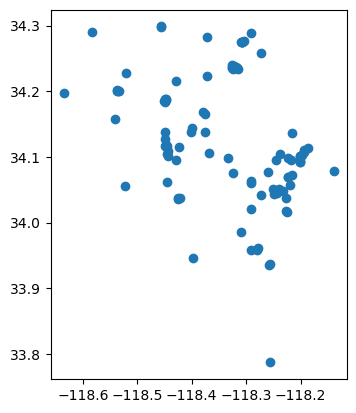

In [129]:
punits.plot()

### Results 

We can see that the number of viable parcels has decreased substaintially. 

## Mapping viable parcels over neighborhoods 

## Mapping viable parcels over high opportunity neighborhoods 

In [130]:
# Import housing and jobs by neighborhood data 
jh=pd.read_csv('data/jh.csv')
jh['geometry'] = jh['geometry'].apply(wkt.loads)
    #add a CRS
jhgdf = gpd.GeoDataFrame(jh, crs="EPSG:4326",geometry='geometry')

jhgdf=jhgdf.drop(columns=['Unnamed: 0.1','Unnamed: 0','OBJECTID','year_x','year_y','square_miles','description','source_link'])
jhgdf.head()

,CITY,Neighborhood,Units of Housing,Number of Jobs,set,slug,region,type,Number of Jobs Per Unit of Housing,geometry,Jobs to Housing Quantiles
0,IN,Pico-Union,13618.70,10516.11,L.A. County Neighborhoods (Current),pico-union,Central L.A.,segment-of-a-city,0.772182,"POLYGON ((-118.29271 34.05291, -118.29161 34.0...",2
1,IN,Sylmar,22156.30,20444.10,L.A. County Neighborhoods (Current),sylmar,San Fernando Valley,segment-of-a-city,0.922722,"POLYGON ((-118.41998 34.32917, -118.41998 34.3...",3
2,IN,North Hills,17637.30,9615.66,L.A. County Neighborhoods (Current),north-hills,San Fernando Valley,segment-of-a-city,0.545189,"POLYGON ((-118.47202 34.25720, -118.47203 34.2...",1
3,IN,Harbor Gateway,13329.57,31028.04,L.A. County Neighborhoods (Current),harbor-gateway,Harbor,segment-of-a-city,2.327760,"POLYGON ((-118.28141 33.92320, -118.28146 33.9...",4
4,IN,Lake Balboa,9621.27,10142.76,L.A. County Neighborhoods (Current),lake-balboa,San Fernando Valley,segment-of-a-city,1.054202,"POLYGON ((-118.50102 34.21540, -118.50092 34.2...",3


In [131]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(jhgdf,k=8)

# Row-standardization
wq.transform = 'r'

### Spatial lag

Now that we have our spatial weights assigned, we use it to calculate the spatial lag. While the mathematical operations are beyond the scope of this lab, you are welcome to check it out [here](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#spatial-lag). Simply put, the spatial lag is a calculated assignment to each geography in your data, which takes into account the data values from others in their  "neighborhood" as defined by the spatial weight. This operation can be done with a single line of code which is part of the pysal module, but the underlying calculations are not that difficult to understand: 

It takes the average of all the neighbors as defined by the spatial weight to come up with a single associated value.

In [132]:
# create a new column for the spatial lag
jhgdf['Number_jobs_div_Housing_Lag'] = lps.weights.lag_spatial(wq, jhgdf['Number of Jobs Per Unit of Housing'])

In [133]:
# take a look at some sample rows
jhgdf.sample(10)[['Neighborhood','Number_jobs_div_Housing_Lag']]

,Neighborhood,Number_jobs_div_Housing_Lag
103,Pacific Palisades,2.080482
57,Beverly Crest,3.726147
41,Lake View Terrace,0.874654
67,Broadway-Manchester,0.319020
104,Bel-Air,3.908144
107,Hyde Park,0.388888
96,Fairfax,1.568128
27,Atwater Village,0.649560
15,Northridge,0.941496
13,Sherman Oaks,0.913528


<div class="alert alert-info">
Take a moment to look at the values in the dataframe. What do they tell you?
</div>

### The donut and the diamond

In [134]:
# create a column that calculates the difference between arrests and lag
jhgdf['JH_lag_diff'] = jhgdf['Number of Jobs Per Unit of Housing'] - jhgdf['Number_jobs_div_Housing_Lag']

In [135]:
# output to get the head and tail
jhgdf.sort_values(by='JH_lag_diff')



,CITY,Neighborhood,Units of Housing,Number of Jobs,set,slug,region,type,Number of Jobs Per Unit of Housing,geometry,Jobs to Housing Quantiles,Number_jobs_div_Housing_Lag,JH_lag_diff
57,IN,Beverly Crest,5183.79,1866.06,L.A. County Neighborhoods (Current),beverly-crest,Westside,segment-of-a-city,0.359980,"POLYGON ((-118.39484 34.11242, -118.39498 34.1...",0,3.726147,-3.366167
31,IN,Cheviot Hills,3564.48,1749.25,L.A. County Neighborhoods (Current),cheviot-hills,Westside,segment-of-a-city,0.490745,"POLYGON ((-118.40121 34.02941, -118.40591 34.0...",1,3.797581,-3.306836
104,IN,Bel-Air,3265.79,3195.01,L.A. County Neighborhoods (Current),bel-air,Westside,segment-of-a-city,0.978327,"POLYGON ((-118.46742 34.12921, -118.46641 34.1...",3,3.908144,-2.929817
66,IN,Pico-Robertson,8543.77,5339.96,L.A. County Neighborhoods (Current),pico-robertson,Westside,segment-of-a-city,0.625012,"POLYGON ((-118.40590 34.05369, -118.40595 34.0...",2,3.385802,-2.760790
54,IN,Beverlywood,2843.32,2141.86,L.A. County Neighborhoods (Current),beverlywood,Westside,segment-of-a-city,0.753295,"POLYGON ((-118.38951 34.04951, -118.38541 34.0...",2,3.463390,-2.710095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,IN,Carthay,2766.49,7745.71,L.A. County Neighborhoods (Current),carthay,Central L.A.,segment-of-a-city,2.799833,"POLYGON ((-118.36151 34.06301, -118.36381 34.0...",4,1.318052,1.481781
3,IN,Harbor Gateway,13329.57,31028.04,L.A. County Neighborhoods (Current),harbor-gateway,Harbor,segment-of-a-city,2.327760,"POLYGON ((-118.28141 33.92320, -118.28146 33.9...",4,0.438078,1.889682
82,IN,Westchester,17434.97,80734.38,L.A. County Neighborhoods (Current),westchester,South Bay,segment-of-a-city,4.630600,"POLYGON ((-118.35855 33.98167, -118.35867 33.9...",4,0.918725,3.711875
37,IN,Downtown,36154.32,335257.20,L.A. County Neighborhoods (Current),downtown,Central L.A.,segment-of-a-city,9.272950,"POLYGON ((-118.22323 34.01495, -118.22339 34.0...",4,1.345876,7.927074


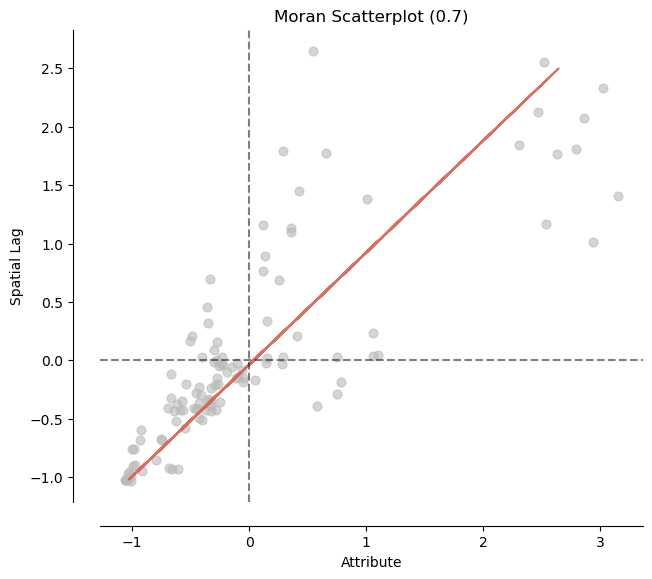

In [136]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [137]:
moran.p_sim

0.001

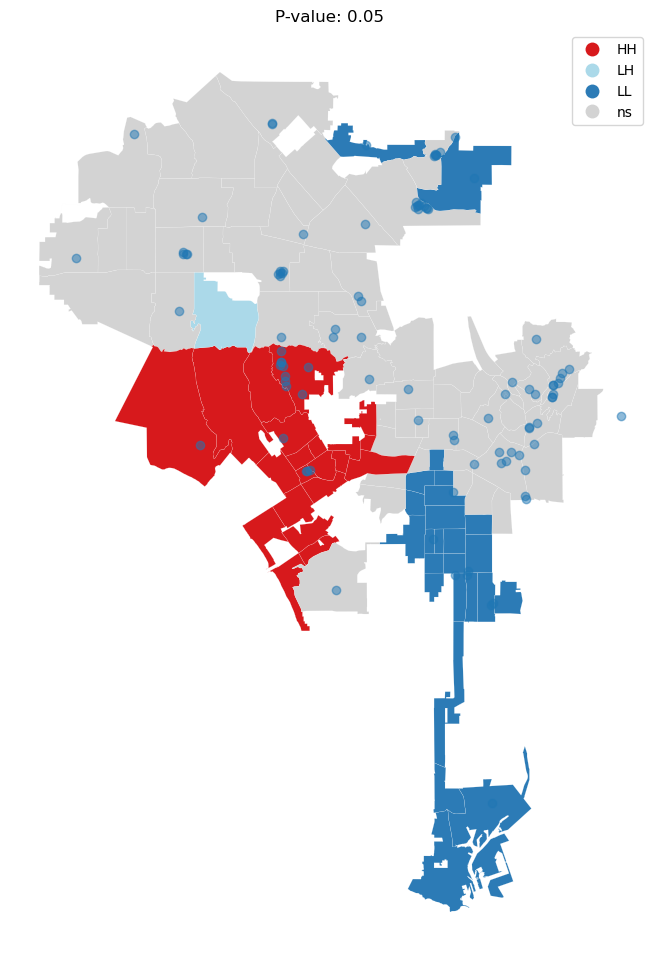

In [138]:
lisa = esda.moran.Moran_Local(y, wq)
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, jhgdf, p=0.05, ax=ax)
ax.axis("off")
ax.set_title("P-value: 0.05")

punits.plot(
            ax=ax,   
            legend = True,     # add a legend        
            alpha = 0.5,
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )
plt.show()

## List of HH Nieghborhoods Just From Clicking Around
I Excluded high fire ones

In [139]:
hhlist=['Beverly Grove', 'Carthay', 'Mid-City', 'Pico Robertson', 'Beverlywood', 'Palms', 'Cheviot Hills', 'Rancho Park', 'West Los Angeles', 'Century City', 'Sawtelle', 'Westwood', 'Venice', 'Mar Vista','Playa Vista', 'Playa Del Rey', 'Westchester','Del Rey',]

## Filtered GDF of Those Nieghborhoods

In [140]:
hopp = jhgdf[jhgdf['Neighborhood'].isin(hhlist)]
hopp.head()

,CITY,Neighborhood,Units of Housing,Number of Jobs,set,slug,region,type,Number of Jobs Per Unit of Housing,geometry,Jobs to Housing Quantiles,Number_jobs_div_Housing_Lag,JH_lag_diff
6,IN,Palms,22173.63,11260.00,L.A. County Neighborhoods (Current),palms,Westside,segment-of-a-city,0.507810,"POLYGON ((-118.38777 34.02907, -118.38817 34.0...",1,3.187697,-2.679886
24,IN,Playa Vista,7065.80,16325.83,L.A. County Neighborhoods (Current),playa-vista,Westside,segment-of-a-city,2.310542,"POLYGON ((-118.39585 33.98490, -118.39568 33.9...",4,1.321640,0.988902
31,IN,Cheviot Hills,3564.48,1749.25,L.A. County Neighborhoods (Current),cheviot-hills,Westside,segment-of-a-city,0.490745,"POLYGON ((-118.40121 34.02941, -118.40591 34.0...",1,3.797581,-3.306836
52,IN,Sawtelle,20857.05,35838.98,L.A. County Neighborhoods (Current),sawtelle,Westside,segment-of-a-city,1.718315,"POLYGON ((-118.44590 34.01944, -118.44593 34.0...",4,3.603559,-1.885244
53,IN,Rancho Park,2459.22,3125.60,L.A. County Neighborhoods (Current),rancho-park,Westside,segment-of-a-city,1.270972,"POLYGON ((-118.41121 34.03081, -118.41511 34.0...",3,3.657499,-2.386527


## Interactive Map with Publicly Owned Vacant Land in those Neighborhoods

In [141]:
m=hopp.explore(
        column='Number_jobs_div_Housing_Lag', # this defines the field to "choropleth"
        legend=True,
        cmap='RdYlGn_r', # the "_r" reverses the color
        scheme='naturalbreaks',
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5
        },
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        )
oppvac.explore(
       
        legend=True,
        m=m,
        
        marker_kwds={'radius':7},
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5
        },
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        )


## Spatial Join of the Two GDFs

In [142]:
oppvac=punits.overlay(hopp, how='intersection')



## Summary of units Possible Per Neighborhood

In [143]:
vc=oppvac.groupby(["Neighborhood"])["TheoreticalUnits"].sum()
vc

Neighborhood
Rancho Park     212.385193
Westchester    2153.189796
Westwood         74.689270
Name: TheoreticalUnits, dtype: float64

In [144]:
punits.explore(
       
        legend=True,
        m=m,
        
        marker_kwds={'radius':7},
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5
        },
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        )